# Modelo de predicción de éxito de las startups

**PARTE 2: SELECCIÓN DE VARIABLES Y CREACIÓN DE MODELOS**

## 1. Importación de librerías

**Librerías generales**

In [1]:
import os
import pandas as pd
import numpy as np
import itertools

**Librerías para gráficos**

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

**Librerías para construcción de modelos**

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix, 
                             precision_score, recall_score, f1_score, accuracy_score)
from sklearn.ensemble import RandomForestClassifier

**Configuración**

In [4]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

## 2. Importación de datos

Importamos los datos de los dos ficheros depurados que vamos a probar:

- **startups_depurado_frequency**: variables categóricas recodificadas con su frecuencia relativa
- **startups_depurado_propsuccess**: variables categóricas recodificadas con su proporción de casos *success*

In [5]:
# Rutas de los ficheros
current_path = os.getcwd() # obtener la ruta donde se guarda este cuaderno
dataset_freq_path = current_path + '/startups_depurado_frequency.csv' # Fichero depurado: Frecuency Encoder
dataset_prop_path = current_path + '/startups_depurado_propsuccess.csv' # Fichero depurado: Proportion Success Encoder

# Lectura de los ficheros
df_startups_freq = pd.read_csv(dataset_freq_path, na_values=['none','None'])
df_startups_prop = pd.read_csv(dataset_prop_path, na_values=['none','None'])

In [6]:
len(df_startups_freq.columns)

111

In [7]:
len(df_startups_prop.columns)

111

## 3. Feature selection

Hacemos la selección de variables mediante el cálculo individual del AUC. Probaremos distintos modelos cambiando el punto de corte *threshold*.

**NOTA:** He ejecutado el código para los dos ficheros y las variables correlacionadas son las mismas, por lo tanto las elimino en los dos ficheros

**POSIBLES VARIABLES CONFLICTIVAS**

En general, todas las variables relacionadas con la experiencia de la empresa no las podemos saber a priori si queremos predecir el éxito/fracaso de las empresas en el momento de la creación. Es información que no vamos a poder tener con las nuevas observaciones.

- **age_years**: directamente relacionada con la variable objetivo (*Success* si la empresa sigue en activo a los X años, *Failed* si cierra antes de X años)
- **fundation_year**: mismo motivo
- **has_team_size_grown**: ha aumentado el tamaño del equipo. Info que a priori no podemos saber.
- **number_repeat_investors**: inversores que repiten. Info que a priori no podemos saber.
- **avg_size_companies_worked_for_past**: tampoco podemos saberlo en el inicio de la empresa
- **breadth_experience_across_verticals**
- **experience_fortune_100_organizations**
- **experience_fortune_500_organizations**
- **experience_fortune_1000_organizations**
- **company_awards**: si tiene premios es porque ha tenido éxito
- **employees_per_year_existence**: los años de existencia no los podemos conocer
- **survival_through_recession**
- **avg_time_to_investment**: a priori no podemos saber.
- **renown_score**: puntuación de renombre. Si tiene renombre es porque ha tenido éxito

Tengo más dudas de estas:
- **days_since_last_funding_date**
- **days_since_est_funding_date**
- **exposure_across_globe**

In [8]:
# Eliminamos variables conflictivas de ambos ficheros
vars_conflict = ["age_years", "fundation_year", "has_team_size_grown", "number_repeat_investors", "avg_size_companies_worked_for_past", "breadth_experience_across_verticals", "experience_fortune_100_organizations", "experience_fortune_500_organizations",
                 "experience_fortune_1000_organizations", "company_awards", "employees_per_year_existence", "survival_through_recession", "avg_time_to_investment", "renown_score", "exposure_across_globe", "days_since_last_funding_date", "days_since_est_funding_date"]

df_noconflict_freq = df_startups_freq.drop(vars_conflict, axis=1)  # fichero STARTUP_FREQUENCY
df_noconflict_prop = df_startups_prop.drop(vars_conflict, axis=1)  # fichero STARTUP_PROPORTION

### 3.1. Estudio de correlaciones

Sacamos un gráfico de correlaciones de las variables numéricas para tratar de eliminar variables que estén muy correlacionadas, ya que aportan información redundante.

#### 3.1.1. Fichero STARTUP_FREQUENCY

In [90]:
df_numeric = df_noconflict_freq.select_dtypes(include=["float64"]) # selecciono numericas
corr_df = df_numeric.corr()

In [91]:
corr_df # matriz de correlaciones

status  internet_score  \
status                                           1.000000        0.202803   
internet_score                                   0.202803        1.000000   
count_employee                                   0.071115        0.139861   
last_funding_amount                             -0.025432        0.067705   
number_investors_seed                            0.131532        0.114626   
number_investors_angel_VC                        0.049643       -0.063713   
number_cofounders                                0.205835        0.089144   
number_advisors                                  0.188963        0.039660   
team_size_senior_lead                            0.255690        0.123083   
team_size_all_employees                          0.036745        0.204459   
years_education                                  0.027094       -0.022166   
renowned_professional_circle                     0.140332        0.091063   
number_recognitions_for_founders_cofounders      0.153254        0.081916   
skills_score                                    -0.025790        0.024571   
google_page_rank_company_web                    -0.194879       -0.242407   
industry_trend_investing                         0.025436       -0.003328   
number_direct_competitors                        0.039833       -0.028976   
last_round_fundind_millionUSD                    0.013187        0.070292   
months_to_1st_investment                         0.076327       -0.005395   
perc_skill_entrepreneur                          0.063521        0.020376   
perc_skill_operations                           -0.036708       -0.084150   
perc_skill_engineering                           0.079733       -0.004266   
perc_skill_marketing                             0.032886        0.087828   
perc_skill_leadership                            0.063092       -0.037954   
perc_skill_datascience                           0.169279        0.031580   
perc_skill_business_strategy                    -0.065240       -0.050652   
perc_skill_product_manag                        -0.054518       -0.006236   
perc_skill_sales                                 0.009310       -0.079295   
perc_skill_domain                               -0.041169       -0.121623   
perc_skill_law                                   0.038897       -0.040585   
perc_skill_consulting                            0.058681       -0.005239   
perc_skill_finance                               0.003311       -0.052541   
perc_skill_investment                           -0.003900        0.005861   
industry                                         0.012164       -0.038585   
focus_functions                                  0.100775        0.092437   
country                                          0.021442       -0.002080   
continent                                        0.043552       -0.018571   
presence_angel_venture_fund                      0.102967        0.037925   
number_sales_support_material                    0.267919       -0.048605   
worked_top_company                               0.024288        0.048503   
part_of_startups_past                            0.114789        0.011491   
part_of_success_startups_past                    0.161857        0.025298   
partner_big5_consulting                          0.053713        0.022892   
consulting_experience                            0.305352        0.086462   
product_or_service_company                       0.036030       -0.006956   
catering_product_service_across_verticals        0.204340        0.059634   
focus_private_or_public_data                    -0.053657       -0.050467   
focus_consumer_data                             -0.071792        0.071789   
focus_structured_unstructured_data               0.200132        0.028617   
subscription_based                               0.169877        0.056974   
cloud_or_platform_based                         -0.188696        0.027429   
local_or_global_player                         

In [92]:
corr_df_abs = corr_df.abs()  # matriz de correlaciones en valor absoluto
upper = corr_df_abs.where(np.triu(np.ones(corr_df_abs.shape), k=1).astype(np.bool))  # triángulo superior de la matriz
vars_to_drop = [c for c in upper.columns if any(upper[c] > 0.75)]  # variables con correlación >0.75

In [93]:
vars_to_drop

['last_round_fundind_millionUSD',
 'continent',
 'part_of_success_startups_past',
 'controversial_history_founder_cofounder',
 'technical_skills_analyse_unstructured_data',
 'solutions_offered']

**Variables correlacionadas**:

- last_round_fundind_millionUSD:
    - last_funding_amount                                0.795699
- continent:
    - country                                            0.966224
- part_of_success_startups_past:
    - part_of_startups_past                              0.841086
- controversial_history_founder_cofounder:
    - proprietary_patent_position                        0.716158
    - hyper_localisation                                 0.719162
    - time_market_service_product                        0.733871
    - difficulty_obtain_workforce                        0.750313
    - legal_risk_intell_property                         0.760663
    - disruptiveness_technology                          0.775242
    - team_composition_score                             0.847335
    - solutions_offered                                  0.905945
    - pricing_strategy                                   0.916762
    - technical_skills_analyse_unstructured_data         0.919250
- technical_skills_analyse_unstructured_data:
    - highest_education                                  0.713242
    - avg_years_experience for founder and co founder    0.729571
    - proprietary_patent_position                        0.746133
    - legal_risk_intell_property                         0.752223
    - long_term_relation_other_founders                  0.753278
    - time_market_service_product                        0.755792
    - hyper_localisation                                 0.756245
    - disruptiveness_technology                          0.791730
    - difficulty_obtain_workforce                        0.799461
    - team_composition_score                             0.885346
    - controversial_history_founder_cofounder            0.919250
    - pricing_strategy                                   0.965417
    - solutions_offered                                  0.967035
- solutions_offered:
    - avg_years_experience for founder and co founder    0.722453
    - highest_education                                  0.723791
    - hyper_localisation                                 0.742106
    - time_market_service_product                        0.765559
    - proprietary_patent_position                        0.766714
    - legal_risk_intell_property                         0.771843
    - long_term_relation_other_founders                  0.773206
    - disruptiveness_technology                          0.784060
    - difficulty_obtain_workforce                        0.800028
    - team_composition_score                             0.890685
    - controversial_history_founder_cofounder            0.905945
    - technical_skills_analyse_unstructured_data         0.967035
    - pricing_strategy                                   0.983764

In [94]:
# Eliminamos variables correlacionadas del fichero STARTUP_FREQUENCY
vars_to_drop_def = ["last_round_fundind_millionUSD", "continent", "part_of_success_startups_past", "technical_skills_analyse_unstructured_data",
                    "pricing_strategy", "controversial_history_founder_cofounder", "team_composition_score", "difficulty_obtain_workforce",
                    "disruptiveness_technology", "long_term_relation_other_founders", "legal_risk_intell_property", "proprietary_patent_position",
                    "time_market_service_product", "hyper_localisation", "highest_education", "avg_years_experience for founder and co founder",
                    "client_reputation", "top_management_similarity", "solutions_offered", "relevance_experience_venture", "google_page_rank_company_web", "invested_through_global_incubation_competitions"]

df_corr_elim_freq = df_noconflict_freq.drop(vars_to_drop_def, axis=1)
df_corr_elim_freq.shape

(472, 72)

In [95]:
input_cols_freq = df_corr_elim_freq.select_dtypes(include=["float64"]).columns.drop('status') # selecciono numericas

#### 3.1.2. Fichero STARTUP_PROPORTION

In [96]:
df_numeric = df_noconflict_prop.select_dtypes(include=["float64"]) # selecciono numericas
corr_df = df_numeric.corr()

In [97]:
corr_df # matriz de correlaciones

status  internet_score  \
status                                           1.000000        0.202803   
internet_score                                   0.202803        1.000000   
count_employee                                   0.071115        0.139861   
last_funding_amount                             -0.025432        0.067705   
number_investors_seed                            0.131532        0.114626   
number_investors_angel_VC                        0.049643       -0.063713   
number_cofounders                                0.205835        0.089144   
number_advisors                                  0.188963        0.039660   
team_size_senior_lead                            0.255690        0.123083   
team_size_all_employees                          0.036745        0.204459   
years_education                                  0.027094       -0.022166   
renowned_professional_circle                     0.140332        0.091063   
number_recognitions_for_founders_cofounders      0.153254        0.081916   
skills_score                                    -0.025790        0.024571   
google_page_rank_company_web                    -0.194879       -0.242407   
industry_trend_investing                         0.025436       -0.003328   
number_direct_competitors                        0.039833       -0.028976   
last_round_fundind_millionUSD                    0.013187        0.070292   
months_to_1st_investment                         0.076327       -0.005395   
perc_skill_entrepreneur                          0.063521        0.020376   
perc_skill_operations                           -0.036708       -0.084150   
perc_skill_engineering                           0.079733       -0.004266   
perc_skill_marketing                             0.032886        0.087828   
perc_skill_leadership                            0.063092       -0.037954   
perc_skill_datascience                           0.169279        0.031580   
perc_skill_business_strategy                    -0.065240       -0.050652   
perc_skill_product_manag                        -0.054518       -0.006236   
perc_skill_sales                                 0.009310       -0.079295   
perc_skill_domain                               -0.041169       -0.121623   
perc_skill_law                                   0.038897       -0.040585   
perc_skill_consulting                            0.058681       -0.005239   
perc_skill_finance                               0.003311       -0.052541   
perc_skill_investment                           -0.003900        0.005861   
industry                                         0.115450       -0.020005   
focus_functions                                  0.157066        0.102823   
country                                          0.051657       -0.005055   
continent                                        0.082191       -0.021006   
presence_angel_venture_fund                      0.142657        0.057951   
number_sales_support_material                    0.465757        0.076252   
worked_top_company                               0.036021        0.052279   
part_of_startups_past                            0.127295        0.018592   
part_of_success_startups_past                    0.191643        0.049676   
partner_big5_consulting                          0.063496        0.027167   
consulting_experience                            0.304666        0.063277   
product_or_service_company                       0.042346       -0.007817   
catering_product_service_across_verticals        0.360891        0.117526   
focus_private_or_public_data                     0.297465        0.039052   
focus_consumer_data                              0.088373        0.067462   
focus_structured_unstructured_data               0.416470        0.071971   
subscription_based                               0.162540        0.054927   
cloud_or_platform_based                         -0.178484        0.025434   
local_or_global_player                         

In [98]:
corr_df_abs = corr_df.abs()  # matriz de correlaciones en valor absoluto
upper = corr_df_abs.where(np.triu(np.ones(corr_df_abs.shape), k=1).astype(np.bool))  # triángulo superior de la matriz
vars_to_drop = [c for c in upper.columns if any(upper[c] > 0.75)]  # variables con correlación >0.75

In [99]:
vars_to_drop

['last_round_fundind_millionUSD',
 'continent',
 'part_of_success_startups_past',
 'pricing_strategy',
 'time_market_service_product',
 'long_term_relation_other_founders',
 'proprietary_patent_position',
 'controversial_history_founder_cofounder',
 'legal_risk_intell_property',
 'technical_skills_analyse_unstructured_data',
 'solutions_offered',
 'disruptiveness_technology']

**Variables correlacionadas**:

- last_round_fundind_millionUSD: 
    - last_funding_amount (0.79)
- continent: 
    - country (0.96)
- part_of_success_startups_past: 
    - part_of_startups_past (0.84)
- pricing_strategy:
    - avg_years_experience for founder and co founder    0.722795
    - highest_education                                  0.724434
    - hyper_localisation                                 0.748862
    - legal_risk_intell_property                         0.761779
    - proprietary_patent_position                        0.762992
    - long_term_relation_other_founders                  0.763557
    - time_market_service_product                        0.776864
    - disruptiveness_technology                          0.787571
    - difficulty_obtain_workforce                        0.797210
    - team_composition_score                             0.910380
    - controversial_history_founder_cofounder            0.916762
    - technical_skills_analyse_unstructured_data         0.965417
    - solutions_offered                                  0.983764
- time_market_service_product:
    - team_composition_score                             0.711910
    - controversial_history_founder_cofounder            0.733871
    - technical_skills_analyse_unstructured_data         0.755792
    - solutions_offered                                  0.765559
    - pricing_strategy                                   0.776864
- long_term_relation_other_founders:
    - team_composition_score                             0.728845
    - technical_skills_analyse_unstructured_data         0.753278
    - pricing_strategy                                   0.763557
    - solutions_offered                                  0.773206
- proprietary_patent_position:
    - controversial_history_founder_cofounder            0.716158
    - team_composition_score                             0.733217
    - technical_skills_analyse_unstructured_data         0.746133
    - pricing_strategy                                   0.762992
    - solutions_offered                                  0.766714
- controversial_history_founder_cofounder:
    - proprietary_patent_position                        0.716158
    - hyper_localisation                                 0.719162
    - time_market_service_product                        0.733871
    - difficulty_obtain_workforce                        0.750313
    - legal_risk_intell_property                         0.760663
    - disruptiveness_technology                          0.775242
    - team_composition_score                             0.847335
    - solutions_offered                                  0.905945
    - pricing_strategy                                   0.916762
    - technical_skills_analyse_unstructured_data         0.919250
- legal_risk_intell_property:
    - team_composition_score                             0.701082
    - technical_skills_analyse_unstructured_data         0.752223
    - controversial_history_founder_cofounder            0.760663
    - pricing_strategy                                   0.761779
    - solutions_offered                                  0.771843
- technical_skills_analyse_unstructured_data:
    - highest_education                                  0.713242
    - avg_years_experience for founder and co founder    0.729571
    - proprietary_patent_position                        0.746133
    - legal_risk_intell_property                         0.752223
    - long_term_relation_other_founders                  0.753278
    - time_market_service_product                        0.755792
    - hyper_localisation                                 0.756245
    - disruptiveness_technology                          0.791730
    - difficulty_obtain_workforce                        0.799461
    - team_composition_score                             0.885346
    - controversial_history_founder_cofounder            0.919250
    - pricing_strategy                                   0.965417
    - solutions_offered                                  0.967035
- solutions_offered:
    - avg_years_experience for founder and co founder    0.722453
    - highest_education                                  0.723791
    - hyper_localisation                                 0.742106
    - time_market_service_product                        0.765559
    - proprietary_patent_position                        0.766714
    - legal_risk_intell_property                         0.771843
    - long_term_relation_other_founders                  0.773206
    - disruptiveness_technology                          0.784060
    - difficulty_obtain_workforce                        0.800028
    - team_composition_score                             0.890685
    - controversial_history_founder_cofounder            0.905945
    - technical_skills_analyse_unstructured_data         0.967035
    - pricing_strategy                                   0.983764
- disruptiveness_technology:
    - team_composition_score                             0.711677
    - controversial_history_founder_cofounder            0.775242
    - solutions_offered                                  0.784060
    - pricing_strategy                                   0.787571
    - technical_skills_analyse_unstructured_data         0.791730

In [100]:
# Eliminamos variables correlacionadas del fichero STARTUP_PROPORTION
vars_to_drop_def = ["last_round_fundind_millionUSD", "continent", "part_of_success_startups_past", "solutions_offered",
                    "technical_skills_analyse_unstructured_data", "controversial_history_founder_cofounder", "team_composition_score",
                    "difficulty_obtain_workforce", "disruptiveness_technology", "time_market_service_product",
                    "long_term_relation_other_founders", "proprietary_patent_position", "legal_risk_intell_property",
                    "hyper_localisation", "highest_education", "avg_years_experience for founder and co founder",
                    "pricing_strategy", "invested_through_global_incubation_competitions", "experience_selling_building_products", "google_page_rank_company_web", "client_reputation"]

df_corr_elim_prop = df_noconflict_prop.drop(vars_to_drop_def, axis=1)
df_corr_elim_prop.shape

(472, 73)

In [101]:
input_cols_prop = df_corr_elim_prop.select_dtypes(include=["float64"]).columns.drop('status') # selecciono numericas

### 3.2. Selección de variables

La selección de variables es diferente en cada dataset

**Selección mediante AUC**

In [102]:
def get_auc(df, score_col, label_col): 
    
    """
    Función que calcula el AUC de una variable con respecto a la variable objetivo
    
    - df: dataframe que contiene la variable input y label
    - score_col: columna de la variable input
    - label_col: columna de la variable objetivo
    
    """
    
    #1. Compruebo dirección de la variable input con respecto a la objetivo (ajuste para que no salgan AUC negativos)
    
    avg_df = df.groupby(label_col)[score_col].mean() #media de la variable input para label=success y label=failure
    avg_failed = avg_df.values[0] #media de la variable input para label=failed
    avg_success = avg_df.values[1] #media de la variable input para label=success
    
    if avg_failed > avg_success: #si la media de la variable input para label=failed es superior que para label=success 

        df[score_col] = -1.0*df[score_col] #paso la variable input a negativa
        
    else: #si la media de la variable input para label=success es superior que para label=failed

        df #dejo la variable input igual
    
    #2. Paso las columnas label e input a array para poder calcular AUC

    x = df[score_col].to_numpy() 
    y = df[label_col].to_numpy()

    #3. Calculo AUC de la variable input con respecto a la variable objetivo
    
    auc = roc_auc_score(y, x) 

    return auc

In [103]:
def feature_selection_auc(df, threshold, cols_to_filter, label_col = 'status'): 

    """
    Función que aplica get_auc sobre todas las variables input y selecciona aquellas con un AUC superior
    
    - df: dataframe que contiene las variables input y label
    - threshold: AUC a partir del cuál me quedo con una variable 
    - cols_to_filter: columnas sobre las que queremos calcular el AUC
    - label_col: columna de la variable objetivo
    """
    
    #1. Calculo AUC de todas las variables input y las guardo en una tupla ordenada de mayor a menor AUC
    
    auc_results = [(f, get_auc(df, score_col=f, label_col=label_col)) for f in cols_to_filter] 
    auc_results = sorted(auc_results, key=lambda tup: tup[1], reverse=True)

    #2. Imprimo por pantalla los resultados
    
    for (f, r) in auc_results:
            print ("[Info] " + f + ": " + str(r))
            
            
    #3. Me quedo con aquellas variables cuyo AUC sea superior al threshold que indiquemos
    
    auc_greater = [list(group) for val, group in itertools.groupby(auc_results, lambda x: x[1] > threshold) if val]
 
    vars_selected = [var for var, auc in auc_greater[0]]
    
    return vars_selected

**NOTA**: Hay que jugar con el punto de corte hasta llegar al número de variables independientes deseado (mínimo 0.5)

## 4. Prueba de diferentes modelos

- ### Modelo 1: Variables categoricas transformadas a su frecuencia, AUC > 0.5

Seleccionamos variables con un AUC superior a 0.5, con el dataset de frecuencias:

In [104]:
vars_selected_freq1 = feature_selection_auc(df_corr_elim_freq, 0.5, input_cols_freq, label_col = 'status') 

[Info] relevance_education_venture: 0.7441150485913419
[Info] local_or_global_player: 0.7277706881319328
[Info] gartner_hype_cycle_stage: 0.7197113968783744
[Info] renowned_professional_circle: 0.7067733385687641
[Info] degree_tier1_tier2_university: 0.6960930597820753
[Info] team_size_senior_lead: 0.6941199568076961
[Info] big_data_business: 0.6909983312064396
[Info] B2C_or_B2B: 0.6855502110533032
[Info] focus_structured_unstructured_data: 0.6720329832139
[Info] aggregator_or_market_place: 0.6571807205261608
[Info] employee_benefits_salary_structures: 0.6538235005399038
[Info] consulting_experience: 0.6406792971434181
[Info] number_cofounders: 0.6267105133994306
[Info] predictive_analytics_business: 0.624305487385884
[Info] number_sales_support_material: 0.6238833807794247
[Info] industry_trend_investing: 0.6139000687150289
[Info] barriers_entry_competitors: 0.6058211445960537
[Info] perc_skill_investment: 0.5956611367429075
[Info] internet_score: 0.5903504466476882
[Info] perc_skill_

In [105]:
len(vars_selected_freq1) #se queda con 55 variables de las 72 que teníamos tras eliminar correladas

55

Creamos el dataset para el primer modelo, con las variables input seleccionadas, la variable target y la identificadora de la empresa

In [106]:
df_model1 = df_startups_freq[['company_name'] + ['status'] + vars_selected_freq1]

Dividimos en train y test: decidimos entrenar con el 70% de los datos y validar con el 30% restante

In [107]:
train1, test1 = train_test_split(df_model1,
                                 train_size=0.7,
                                 test_size=0.3)

Aplicamos el modelo con los datos de train (parámetro class_weight para balancear)

In [108]:
model1_rf = RandomForestClassifier(class_weight='balanced')  # class 1: 64.6%, class 0: 35.4%

In [109]:
model1 = model1_rf.fit(train1[vars_selected_freq1],
                       train1['status'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sacamos importancia de variables del modelo entrenado:

In [110]:
feat_importances_model1 = pd.DataFrame(model1.feature_importances_,
                                       index=vars_selected_freq1,
                                       columns=['importance']).sort_values('importance', ascending=False)

In [111]:
feat_importances_model1

importance
focus_structured_unstructured_data             0.150415
relevance_education_venture                    0.121998
internet_score                                 0.066205
industry_trend_investing                       0.051801
number_sales_support_material                  0.049497
renowned_professional_circle                   0.042489
big_data_business                              0.038218
perc_skill_investment                          0.030880
perc_skill_datascience                         0.027829
specialization_highest_education               0.027477
last_funding_amount                            0.024465
cloud_or_platform_based                        0.022251
years_education                                0.021340
employee_benefits_salary_structures            0.021120
perc_skill_product_manag                       0.019772
team_size_senior_lead                          0.016099
skills_score                                   0.014613
gartner_hype_cycle_stage                       0.014344
number_recognitions_for_founders_cofounders    0.013693
perc_skill_entrepreneur                        0.013416
linear_nonlinear_business                      0.012367
number_investors_seed                          0.012288
presence_angel_venture_fund                    0.010399
degree_tier1_tier2_university                  0.010223
perc_skill_engineering                         0.010087
partner_big5_consulting                        0.009839
perc_skill_business_strategy                   0.009536
consulting_experience                          0.008649
subscription_based                             0.007895
number_cofounders                              0.007820
aggregator_or_market_place                     0.007624
capital_intensive                              0.007301
barriers_entry_competitors                     0.006881
predictive_analytics_business                  0.006871
local_or_global_player                         0.006710
perc_skill_domain                              0.006691
number_advisors                                0.006666
focus_private_or_public_data                   0.006186
perc_skill_operations                          0.006051
industry                                       0.005950
top_forums_talking_about_company               0.005715
product_or_service_company                     0.005675
B2C_or_B2B                                     0.005439
prescriptive_analytics_business                0.005110
crowdsourcing_business                         0.004622
worked_top_company                             0.004325
country                                        0.003373
owns_data                                      0.003160
part_of_startups_past                          0.002832
online_or_offline_business                     0.002487
ML_business                                    0.002451
focus_consumer_data                            0.000852
crowdfunding_business                          0.000000
cross_channel_analytics_or_marketing           0.000000
speech_analytics_business                      0.000000

**Evaluación del modelo: Curva ROC y AUC**

In [112]:
test = test1
model = model1
feature_columns = vars_selected_freq1

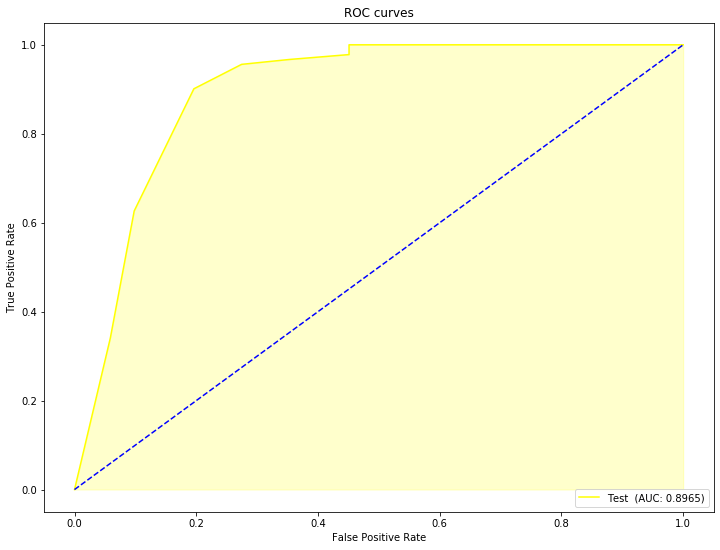

In [113]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict_proba(test[feature_columns])[:, 1], pos_label=1.0)
df_roc_test = pd.DataFrame({"fpr": fpr, "tpr": tpr})

auc_test = roc_auc_score(test['status'],
                         model.predict_proba(test[feature_columns])[:, 1])

# ROC plotting
plt.figure(figsize=(12, 9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"],
         "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0, 1], [0, 1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"],
                 y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [114]:
auc_test

0.89646627881922

In [115]:
auc_train = roc_auc_score(train1['status'],
                          model.predict_proba(train1[feature_columns])[:, 1])

In [116]:
auc_train

0.9999194328069609

**COMENTARIO**: El AUC en train es demasiado alto (prácticamente 1), y hay algo de overfitting (en test el AUC es inferior). Sin embargo, no podemos decir que haya demasiado overfitting, ya que prácticamente son igual de altos. 

- ### Modelo 2: Variables categoricas transformadas a proporción Success, AUC > 0.5

Ahora seleccionamos variables con un AUC superior a 0.5, con el dataset de proporción objetivo:

In [117]:
vars_selected_prop2 = feature_selection_auc(df_corr_elim_prop, 0.5, input_cols_prop, label_col = 'status') 

[Info] relevance_experience_venture: 0.7600274860115834
[Info] relevance_education_venture: 0.7441150485913419
[Info] focus_structured_unstructured_data: 0.7396682045744576
[Info] local_or_global_player: 0.7277706881319328
[Info] big_data_business: 0.7209384509669187
[Info] top_management_similarity: 0.7135761264356532
[Info] renowned_professional_circle: 0.7067733385687641
[Info] degree_tier1_tier2_university: 0.6960930597820753
[Info] team_size_senior_lead: 0.6941199568076961
[Info] number_sales_support_material: 0.6896142141945617
[Info] B2C_or_B2B: 0.6855502110533032
[Info] catering_product_service_across_verticals: 0.6815058407774615
[Info] top_forums_talking_about_company: 0.6718759202905664
[Info] gartner_hype_cycle_stage: 0.6636399332482575
[Info] aggregator_or_market_place: 0.6571807205261608
[Info] focus_private_or_public_data: 0.6569254932757436
[Info] focus_functions: 0.6539020320015706
[Info] employee_benefits_salary_structures: 0.6538235005399038
[Info] specialization_hig

In [118]:
len(vars_selected_prop2) #se queda con 59 variables de las 73 que teníamos tras eliminar correladas

59

In [119]:
df_model2 = df_startups_prop[['company_name'] + ['status'] + vars_selected_prop2]

In [120]:
train2, test2 = train_test_split(df_model2,
                                 train_size=0.7,
                                 test_size=0.3)

In [121]:
model2_rf = RandomForestClassifier(class_weight='balanced')  # class 1: 64.6%, class 0: 35.4%

In [122]:
model2 = model2_rf.fit(train2[vars_selected_prop2],
                       train2['status'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [123]:
feat_importances_model2 = pd.DataFrame(model2.feature_importances_,
                                       index=vars_selected_prop2,
                                       columns=['importance']).sort_values('importance', ascending=False)

In [124]:
feat_importances_model2

importance
number_sales_support_material                  0.096761
relevance_experience_venture                   0.071013
top_management_similarity                      0.067179
focus_structured_unstructured_data             0.063332
industry_trend_investing                       0.051784
big_data_business                              0.043656
renowned_professional_circle                   0.041849
focus_private_or_public_data                   0.035999
internet_score                                 0.035704
degree_tier1_tier2_university                  0.031906
relevance_education_venture                    0.029588
number_recognitions_for_founders_cofounders    0.026691
specialization_highest_education               0.025581
team_size_senior_lead                          0.024723
local_or_global_player                         0.023748
skills_score                                   0.018599
perc_skill_entrepreneur                        0.016293
B2C_or_B2B                                     0.016220
last_funding_amount                            0.015928
aggregator_or_market_place                     0.014770
focus_functions                                0.014695
barriers_entry_competitors                     0.013339
catering_product_service_across_verticals      0.013164
top_forums_talking_about_company               0.012460
country                                        0.012012
industry                                       0.012011
perc_skill_datascience                         0.010915
perc_skill_operations                          0.010227
employee_benefits_salary_structures            0.010091
time_maturity_technology                       0.009827
years_education                                0.009732
gartner_hype_cycle_stage                       0.009693
perc_skill_business_strategy                   0.009485
number_investors_seed                          0.008385
perc_skill_engineering                         0.007941
consulting_experience                          0.006889
perc_skill_domain                              0.006675
cloud_or_platform_based                        0.006579
part_of_startups_past                          0.006118
linear_nonlinear_business                      0.005677
perc_skill_product_manag                       0.005629
number_cofounders                              0.005528
perc_skill_investment                          0.005284
crowdsourcing_business                         0.005006
predictive_analytics_business                  0.004193
prescriptive_analytics_business                0.004087
ML_business                                    0.004048
capital_intensive                              0.003610
presence_angel_venture_fund                    0.003572
subscription_based                             0.003559
product_or_service_company                     0.002717
cross_channel_analytics_or_marketing           0.002079
number_advisors                                0.001800
speech_analytics_business                      0.000873
online_or_offline_business                     0.000776
crowdfunding_business                          0.000000
worked_top_company                             0.000000
partner_big5_consulting                        0.000000
owns_data                                      0.000000

**Evaluación del modelo: Curva ROC y AUC**

In [125]:
test = test2
model = model2
feature_columns = vars_selected_prop2

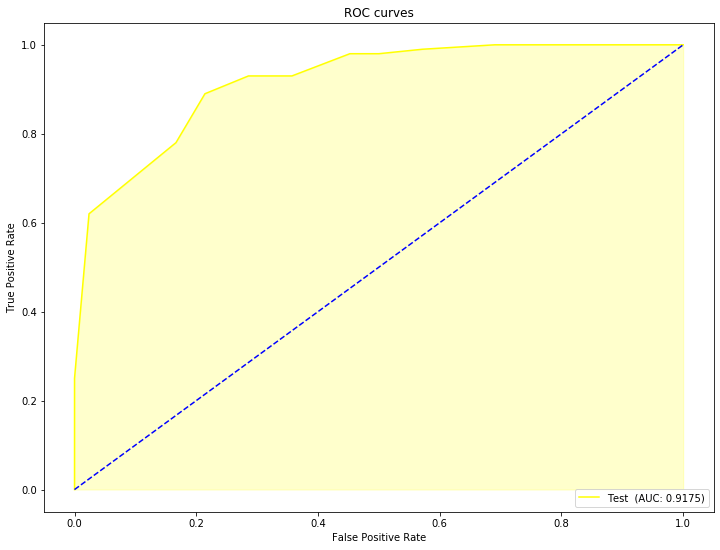

In [126]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict_proba(test[feature_columns])[:, 1],
                        pos_label=1.0
                        )
df_roc_test = pd.DataFrame({"fpr": fpr,
                            "tpr": tpr})

auc_test = roc_auc_score(test['status'],
                         model.predict_proba(test[feature_columns])[:, 1])

# ROC plotting
plt.figure(figsize=(12, 9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"],
         "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0, 1], [0, 1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"],
                 y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [127]:
auc_test

0.9175

In [128]:
auc_train = roc_auc_score(train2['status'],
                          model.predict_proba(train2[feature_columns])[:, 1])

In [129]:
auc_train

0.9999609756097562

**COMENTARIO**: Aquí el AUC en test aumenta un poco, y en train sigue igual que en el anterior modelo (prácticamente 1)

- ### Modelo 3: Variables categoricas transformadas a proporción Success, AUC > 0.6

Ahora, con el dataset de proporción objetivo, probamos a aumentar el threshold de AUC para introducir menos variables en el modelo (no es recomendable que tengamos casi el mismo número de variables que de observaciones en los datos de test)

In [130]:
vars_selected_prop3 = feature_selection_auc(df_corr_elim_prop, 0.6, input_cols_prop, label_col='status')

[Info] relevance_experience_venture: 0.7600274860115834
[Info] relevance_education_venture: 0.7441150485913419
[Info] focus_structured_unstructured_data: 0.7396682045744576
[Info] local_or_global_player: 0.7277706881319328
[Info] big_data_business: 0.7209384509669187
[Info] top_management_similarity: 0.7135761264356532
[Info] renowned_professional_circle: 0.7067733385687641
[Info] degree_tier1_tier2_university: 0.6960930597820753
[Info] team_size_senior_lead: 0.6941199568076961
[Info] number_sales_support_material: 0.6896142141945617
[Info] B2C_or_B2B: 0.6855502110533032
[Info] catering_product_service_across_verticals: 0.6815058407774615
[Info] top_forums_talking_about_company: 0.6718759202905664
[Info] gartner_hype_cycle_stage: 0.6636399332482575
[Info] aggregator_or_market_place: 0.6571807205261608
[Info] focus_private_or_public_data: 0.6569254932757436
[Info] focus_functions: 0.6539020320015706
[Info] employee_benefits_salary_structures: 0.6538235005399038
[Info] specialization_hig

In [131]:
len(vars_selected_prop3) #se queda con 24 variables

24

In [132]:
df_model3 = df_startups_prop[['company_name'] + ['status'] + vars_selected_prop3]

In [133]:
train3, test3 = train_test_split(df_model3,
                                 train_size=0.7,
                                 test_size=0.3)

In [134]:
model3_rf = RandomForestClassifier(class_weight='balanced')  # class 1: 64.6%, class 0: 35.4%

In [135]:
model3 = model3_rf.fit(train3[vars_selected_prop3],
                       train3['status'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [136]:
feat_importances_model3 = pd.DataFrame(model3.feature_importances_,
                                       index=vars_selected_prop3,
                                       columns=['importance']).sort_values('importance', ascending=False)

In [137]:
feat_importances_model3

importance
relevance_experience_venture                 0.090168
focus_structured_unstructured_data           0.081271
number_sales_support_material                0.077935
top_management_similarity                    0.074350
renowned_professional_circle                 0.070282
local_or_global_player                       0.065896
relevance_education_venture                  0.065212
focus_private_or_public_data                 0.064285
gartner_hype_cycle_stage                     0.064259
specialization_highest_education             0.054704
focus_functions                              0.042032
team_size_senior_lead                        0.038440
catering_product_service_across_verticals    0.035913
barriers_entry_competitors                   0.033189
industry_trend_investing                     0.027072
top_forums_talking_about_company             0.025425
number_cofounders                            0.022311
degree_tier1_tier2_university                0.014739
big_data_business                            0.013446
employee_benefits_salary_structures          0.011239
predictive_analytics_business                0.007650
consulting_experience                        0.007479
B2C_or_B2B                                   0.006827
aggregator_or_market_place                   0.005877

**Evaluación del modelo: Curva ROC y AUC**

In [138]:
test=test3
model=model3
feature_columns=vars_selected_prop3

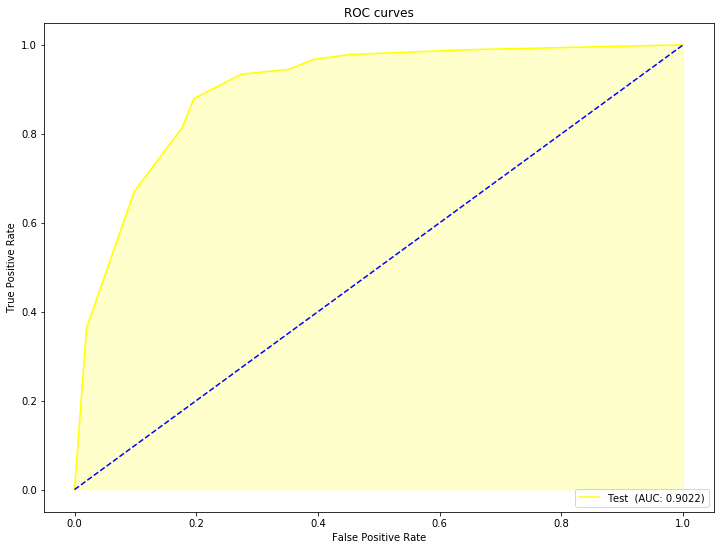

In [139]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict_proba(test[feature_columns])[:,1],
                        pos_label=1.0
                       )
df_roc_test = pd.DataFrame({"fpr":fpr, 
                            "tpr":tpr})

auc_test = roc_auc_score(test['status'], 
                         model.predict_proba(test[feature_columns])[:,1])

# ROC plotting
plt.figure(figsize=(12,9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"], "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0,1],[0,1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"], y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [140]:
auc_test

0.9021762551174316

In [141]:
auc_train = roc_auc_score(train3['status'], 
                         model.predict_proba(train3[feature_columns])[:,1])

In [142]:
auc_train

0.9998791492104415

**COMENTARIO**: Aquí tenemos un resultado similar al del modelo anterior. Sin embargo, hemos introducido casi la mitad de variables, por lo que este modelo es más recomendable

- ### Modelo 3_1: Variables categoricas transformadas a proporción Success, AUC > 0.6 + Grid search Cross Validation

Una técnica para reducir el sobreajuste es la validación cruzada. Utilizamos GridSearchCV, que nos permite entrenar de forma automática distintos modelos, variando para cada uno de ellos el conjunto de entrenamiento seleccionado y los valores de los hiperparámetros.

Utilizamos el mismo dataset que en el modelo anterior (categóricas transformadas a proporción objetivo, filtrando variables por AUC>0.6): train3, test3

In [68]:
model3_1_rf = RandomForestClassifier(class_weight='balanced')

param_grid3_1 = {"n_estimators": [100, 200, 300, 500, 1000],  # hiperparámetros a probar (todas las combinaciones posibles)
                 "max_features": ["sqrt", 0.3, 0.6],
                 "max_depth": [None, 10, 15, 20, 30],
                 "min_samples_split": [2, 5, 10],
                 "n_jobs": [-1],
                 "class_weight": ["balanced"]
                 }

grid3_1 = GridSearchCV(estimator=model3_1_rf,
                       param_grid=param_grid3_1,
                       scoring="roc_auc",  # métrica de evaluación: AUC
                       cv=5,  # número de "folds": conjuntos de entrenamiento con los que se prueba cada combinación de parámetros
                       verbose=3)

In [69]:
model3_1 = grid3_1.fit(train3[vars_selected_prop3],
                       train3['status'])  
# prueba 375 modelos diferentes (5 conjuntos de entrenamiento por cada combinación del grid)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.985, total=   3.5s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.981, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.966, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.934, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.886, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.983, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.982, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.971, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.941, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.935, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.899, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.981, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.986, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.969, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.939, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.883, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.888, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.981, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.972, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.972, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.929, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.881, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.984, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, 

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.971, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.968, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.939, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.890, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.899, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.982, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.984, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.970, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.970, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.938, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.899, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.981, total=   1.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.979, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.964, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.937, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.888, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.885, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.982, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.980, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.971, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.974, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.938, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.892, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.980, total=   1.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.981, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.971, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.971, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.938, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.937, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.888, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.977, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.967, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.982, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.967, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.937, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.896, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.901, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.972, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.992, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.968, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.969, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.945, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.905, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.984, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.983, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.980, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.967, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.936, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.935, total=   1.1s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.896, total=   0.8s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.983, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.980, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[C

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.965, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.974, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.934, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.881, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.878, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.981, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.963, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.969, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.969, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.936, total=   1.0s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.898, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.984, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.978, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.985, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.969, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.942, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.937, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.893, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.984, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.984, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.983, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.971, total=   1.1s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.935, total=   0.9s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.898, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.897, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.987, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.968, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.967, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.970, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.935, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.881, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.982, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.979, total=   1.1s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.965, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.965, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.936, total=   1.0s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.932, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.895, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.981, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.988, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.986, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.971, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.940, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.894, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.888, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.982, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.980, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.967, total=   1.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.932, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.900, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.977, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.984, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.972, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.968, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.934, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.880, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.873, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.983, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.968, total=   1.1s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.968, total=   1.0s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[

[Parallel(n_jobs=1)]: Done 1125 out of 1125 | elapsed:  7.7min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


**Elección del mejor modelo**

Aquí se muestra un resumen de todos los modelos entrenados: el primero es el que tiene mayor media de AUC en los datos de validación (mean_test_score)

In [70]:
pd.DataFrame(model3_1.cv_results_).sort_values(by="mean_test_score", ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
52        0.186120      0.007079         0.106974        0.000740   
188       0.290977      0.012413         0.106983        0.001837   
1         0.154246      0.038420         0.105698        0.000627   
183       0.277607      0.007457         0.107195        0.001560   
136       0.130961      0.006667         0.106428        0.001250   
2         0.167164      0.005220         0.105691        0.000490   
190       0.151879      0.002583         0.109302        0.000726   
143       0.273602      0.008410         0.109384        0.005072   
155       0.093581      0.005012         0.106251        0.001185   
46        0.137083      0.008665         0.106334        0.000887   
9         0.605785      0.191817         0.166976        0.049902   
47        0.187980      0.009372         0.106652        0.001422   
96        0.182567      0.054476         0.107845        0.002698   
14        0.635402      0.174596         0.146103        0.050520   
191       0.128836      0.006544         0.105659        0.000332   
189       0.617140      0.194098         0.167997        0.051285   
103       0.342783      0.099712         0.107241        0.001360   
102       0.178420      0.005126         0.106616        0.001071   
146       0.166760      0.049075         0.106084        0.001829   
106       0.130498      0.004217         0.106385        0.001146   
186       0.138366      0.009007         0.105711        0.001149   
53        0.305729      0.050591         0.108874        0.003393   
94        0.611776      0.199178         0.126472        0.041710   
92        0.184403      0.011193         0.107192        0.000835   
184       0.628160      0.185311         0.147737        0.052163   
139       0.645608      0.179427         0.146425        0.050779   
54        0.760373      0.204745         0.146892        0.051420   
95        0.132024      0.029692         0.108720        0.001775   
182       0.181011      0.007349         0.106402        0.001007   
48        0.366416      0.115547         0.106776        0.001400   
56        0.144721      0.004545         0.106769        0.001110   
7         0.187080      0.010748         0.106596        0.000554   
112       0.178830      0.009110         0.105925        0.000780   
144       0.629271      0.176127         0.126274        0.042260   
4         0.697683      0.195161         0.189285        0.040735   
137       0.179103      0.007394         0.106282        0.000796   
45        0.106495      0.018705         0.107043        0.001296   
90        0.101983      0.007297         0.107707        0.001624   
201       0.152582      0.010869         0.105561        0.000703   
59        0.653609      0.181787         0.125874        0.041297   
193       0.271262      0.009300         0.106819        0.001438   
198       0.402011      0.095945         0.107200        0.000653   
101       0.150478      0.043438         0.107125        0.000648   
8         0.269261      0.007599         0.106517        0.001165   
51        0.143910      0.004553         0.108280        0.000587   
153       0.378575      0.119820         0.107558        0.000919   
192       0.173158      0.007486         0.105788        0.000510   
149       0.631478      0.195879         0.147219        0.051721   
194       0.727393      0.208800         0.167842        0.051376   
110       0.096726      0.013287         0.108045        0.001403   
99        0.632681      0.166844         0.146097        0.050102   
108       0.283019      0.012989         0.106348        0.001343   
5         0.120698      0.028002         0.110143        0.001984   
138       0.284323      0.018580         0.106427        0.001410   
91        0.133201      0.007828         0.106212        0.000344   
159       0.648296      0.161942         0.126606        0.041977   
150       0.104728      0.013995         0.107163        0.001285   
142

In [71]:
model3_1_best=model3_1.best_estimator_ #mejor modelo

In [72]:
feat_importances_model3_1 = pd.DataFrame(model3_1_best.feature_importances_,
                                   index = vars_selected_prop3,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [73]:
feat_importances_model3_1

importance
invested_through_global_incubation_competitions    0.126689
google_page_rank_company_web                       0.120039
experience_selling_building_products               0.064014
number_sales_support_material                      0.063914
client_reputation                                  0.056854
focus_structured_unstructured_data                 0.054556
specialization_highest_education                   0.044720
pricing_strategy                                   0.041174
relevance_education_venture                        0.038796
renowned_professional_circle                       0.037203
top_management_similarity                          0.029838
focus_functions                                    0.028418
industry_trend_investing                           0.026481
relevance_experience_venture                       0.024426
gartner_hype_cycle_stage                           0.023705
B2C_or_B2B                                         0.023271
local_or_global_player                             0.023089
focus_private_or_public_data                       0.022224
catering_product_service_across_verticals          0.022157
team_size_senior_lead                              0.020951
top_forums_talking_about_company                   0.019167
big_data_business                                  0.019010
employee_benefits_salary_structures                0.016619
degree_tier1_tier2_university                      0.015898
number_cofounders                                  0.009793
barriers_entry_competitors                         0.007765
consulting_experience                              0.006759
aggregator_or_market_place                         0.006718
predictive_analytics_business                      0.005750

**Evaluación del modelo: Curva ROC y AUC**

In [74]:
test = test3
model = model3_1_best
feature_columns = vars_selected_prop3

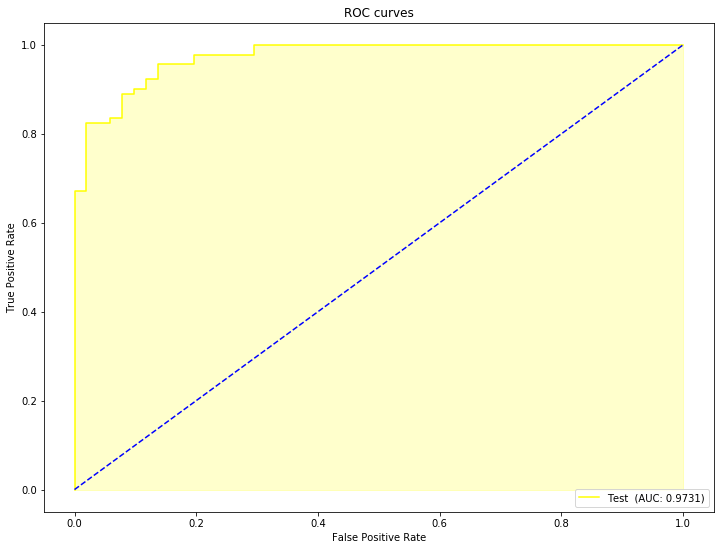

In [75]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict_proba(
                            test[feature_columns])[:, 1],
                        pos_label=1.0
                        )
df_roc_test = pd.DataFrame({"fpr": fpr,
                            "tpr": tpr})

auc_test = roc_auc_score(test['status'],
                         model.predict_proba(test[feature_columns])[:, 1])

# ROC plotting
plt.figure(figsize=(12, 9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"],
         "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0, 1], [0, 1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"],
                 y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [76]:
auc_test

0.9730661495367378

In [77]:
auc_train = roc_auc_score(train3['status'], 
                         model.predict_proba(train3[feature_columns])[:,1])

In [78]:
auc_train

0.9999597164034805

**COMENTARIO**: Tras realizar validación cruzada, el AUC en test y en train sigue siendo similar.

Aunque parezca raro que el AUC sea tan alto, no es un problema de sobreajuste ya que se ha probado el modelo entrenando con distintos conjuntos y se ha evaluado sobre un conjunto de test con el que no se ha entrenado el modelo y aún así sale igual de alto **(al final probamos también validación cruzada repetida)**

**Evaluación del modelo: Matriz de confusión y métricas**

Hasta ahora hemos evaluado los modelos mediante el AUC, ya que es la métrica más adecuada para comparar modelos (se basa en cómo de bien clasifica el modelo para distintos umbrales). 

Sin embargo, hay otras métricas más fáciles de interpretar: las relacionadas con la matriz de confusión. Calcularemos dichas métricas sobre los datos de test para el último modelo obtenido.

Estas métricas se basan en comparar los valores reales de la variable target con los valores predichos por el modelo (estos se pueden obtener con *model.predict*). El threshold por defecto es 0.5, es decir: cuando el scoring proporcionado por el modelo es superior a 0.5, se clasifica la observación como 1 (Success). Como el dataset se ha balanceado al aplicar el modelo, un threshold de 0.5 será adecuado.

In [79]:
pred_model3_1_best=model.predict(test[feature_columns])  #valores predichos por el modelo

Calculamos la matriz de confusión sobre los datos de test a partir de los valores reales y los predichos:

In [80]:
conf_model3_1=confusion_matrix(test['status'], pred_model3_1_best)

In [81]:
conf_model3_1

array([[37, 14],
       [ 2, 89]], dtype=int64)

Hay 14 observaciones en test que el modelo clasifica como Success y en realidad fueron Failed, y 2 observaciones que el modelo clasificó como Failed y en realidad fueron Sucess

Ahora, calculamos las distintas métricas derivadas de esta matriz de confusión e interpretamos resultados:

In [82]:
precision_model3_1=precision_score(test['status'], pred_model3_1_best)
recall_model3_1=recall_score(test['status'], pred_model3_1_best)
f1_model3_1=f1_score(test['status'], pred_model3_1_best)
accuracy_model3_1=accuracy_score(test['status'], pred_model3_1_best)

In [83]:
precision_model3_1

0.8640776699029126

- Interpretación precision: Un 89.4% de las observaciones clasificadas como 1, realmente son 1 (de las empresas que determinamos que van a tener éxito, un 89.4% realmente lo tienen)

In [84]:
recall_model3_1

0.978021978021978

- Interpretación recall: El modelo consigue detectar un 91.5% de las empresas que van a tener éxito (de entre todas las empresas que realmente tienen éxito, un 91.5% fueron predichas por el modelo)

In [85]:
f1_model3_1

0.9175257731958761

- Interpretación f1: compromiso entre precision y recall

In [86]:
accuracy_model3_1

0.8873239436619719

- Interpretación accuracy: El modelo acierta un 88.7% de las veces

- ### Modelo 3_2: Variables categoricas transformadas a proporción Success, AUC > 0.6 + Grid search Repeated Cross Validation

Probamos el último modelo, pero con validación cruzada repetida

In [143]:
model3_2_rf= RandomForestClassifier(class_weight='balanced')

param_grid3_2 = {"n_estimators": [100, 200, 300, 500, 1000],  # hiperparámetros a probar (todas las combinaciones posibles)
                 "max_features": ["sqrt", 0.3, 0.6],
                 "max_depth": [None, 10, 15, 20, 30],
                 "min_samples_split": [2, 5, 10],
                 "n_jobs": [-1],
                 "class_weight": ["balanced"]
                 }


rkf3_2 = RepeatedKFold(n_splits=5, n_repeats=5, random_state=2652124)

grid3_2 = GridSearchCV(estimator=model3_2_rf,
                     param_grid=param_grid3_2,
                     scoring="roc_auc", # métrica de evaluación: AUC
                     cv=rkf3_2, # usamos el repeated k-fold definido
                     verbose=3)

In [144]:
model3_2 = grid3_2.fit(train3[vars_selected_prop3],
                       train3['status'])  # prueba 375 modelos diferentes (5 conjuntos de entrenamiento por cada combinación del grid)

Fitting 25 folds for each of 225 candidates, totalling 5625 fits
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.978, total=   3.0s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.976, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.922, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.963, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.943, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.913, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.969, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.935, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.976, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.997, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.937, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.951, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.957, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.978, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.928, total=   1.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.961, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.943, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_esti

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.913, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.973, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.935, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.971, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.995, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.940, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.947, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.961, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.979, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.924, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.958, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.942, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.985, total=   1.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.914, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.966, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.928, total=   0.9s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_esti

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.929, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.996, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.942, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.948, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_est

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.976, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.978, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.935, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.957, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_est

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.987, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.911, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.969, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_est

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.955, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.938, total=   1.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.925, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.996, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.955, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.933, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.976, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.915, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.971, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.987, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.983, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.961, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.935, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.925, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.958, total=   1.1s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.961, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.940, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.980, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.959, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.902, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.958, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.961, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.977, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.981, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.951, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.932, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.956, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.956, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.957, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.935, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=1000, n_

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.940, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.956, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.902, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.955, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.919, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.975, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.976, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.949, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.949, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.951, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.957, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.959, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.940, total=   0.9s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.959, total=   1.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.906, total=   0.9s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_esti

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.931, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.975, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.985, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.929, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.944, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.951, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.955, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.943, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.952, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.907, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.952, total=   0.8s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.926, total=   1.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.974, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.983, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.935, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.941, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.940, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.963, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.914, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.961, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.944, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.955, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.905, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.941, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.925, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.974, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.998, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.941, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.944, total=   1.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.956, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.965, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.916, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.945, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.908, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.945, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.923, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.907, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.995, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.941, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.953, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.985, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.982, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.936, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.966, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.960, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.990, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.912, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.966, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.944, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.922, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.995, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.940, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.939, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.981, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.978, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.933, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jo

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.962, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.985, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.915, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.970, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.942, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.931, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.996, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.942, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.941, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.976, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.975, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.934, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.957, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.965, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.985, total=   1.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.910, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.944, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.930, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.930, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.996, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.961, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.937, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.980, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.910, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.954, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.962, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.983, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.982, total=   0.9s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.959, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.938, total=   0.9s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.923, total=   1.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.960, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.959, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.943, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.976, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.909, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.961, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.962, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.983, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.955, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.935, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.924, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.997, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.960, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.946, total=   0.9s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.975, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.966, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV] 

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.957, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.965, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.980, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.911, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.931, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.926, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.997, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.941, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.975, total=   1.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.976, total=   1.1s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.927, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.963, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.982, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.907, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.970, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.925, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.928, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.996, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.940, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.950, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.977, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.969, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.919, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.959, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.964, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.983, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.909, total=   1.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.968, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.915, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.910, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.997, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.927, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.977, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.969, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.922, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.965, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.983, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.908, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.954, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.924, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.915, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.997, total=   1.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.944, total=   0.9s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.956, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.974, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.969, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.920, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.964, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.978, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.909, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.947, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.927, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.997, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.940, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.947, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.956, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.963, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.907, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.962, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.943, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.895, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.954, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.919, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.907, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.998, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.940, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.949, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.975, total=   1.1s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.970, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.923, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.957, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.987, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.906, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.963, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.939, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.936, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.993, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.943, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.951, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.973, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.984, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.934, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.960, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.962, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.988, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.914, total=   1.1s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.973, total=   0.9s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.940, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.918, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.997, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.940, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.949, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.983, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.977, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.929, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.956, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.961, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.987, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.916, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.961, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.943, total=   1.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.928, total=   0.9s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.997, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.961, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.929, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.983, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.972, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.905, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.955, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.966, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.985, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.980, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.959, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.939, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.925, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.959, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.961, total=   1.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.940, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.968, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=100, n_jo

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.958, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.907, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.965, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.956, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.982, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.956, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.933, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.920, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.961, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.946, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.976, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.978, total=   0.8s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.910, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.968, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.963, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.988, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.958, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.934, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.922, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.996, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.951, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.979, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.974, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.924, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.959, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.961, total=   0.9s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.982, total=   1.1s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.913, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.936, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.928, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.997, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.942, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.941, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.984, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.974, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.931, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.956, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.962, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.980, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.909, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.948, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.931, total=   0.8s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.918, total=   1.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.997, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.954, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.937, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.976, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.968, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.959, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.963, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.980, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.901, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.927, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.922, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.997, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.941, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.940, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.978, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.971, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.923, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  c

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.944, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.980, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.910, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.924, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.998, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.943, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.944, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.970, total=   0.8s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.925, total=   0.8s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.964, total=   1.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.945, total=   0.8s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.976, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.911, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.953, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.912, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.907, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.995, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.939, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.946, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.977, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.969, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.923, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.956, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.959, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.981, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.903, total=   1.1s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.947, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.943, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.934, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.993, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.940, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.950, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.980, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.928, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.963, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.991, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.921, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.958, total=   0.8s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.942, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.930, total=   0.8s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.997, total=   0.9s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_j

[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.936, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.987, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.981, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.931, total=   0.2s


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.961, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.964, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.983, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.911, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.957, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.944, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.928, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.997, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.965, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.947, total=   1.1s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.978, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.974, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.905, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.958, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.961, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.981, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.982, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.961, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.942, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.933, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.960, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.941, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.978, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=1000, 

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.956, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.905, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.965, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.962, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.983, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.949, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.939, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.922, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.940, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.978, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.975, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.910, total=   1.1s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.964, total=   1.0s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.961, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.988, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.986, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.957, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.925, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.921, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.960, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.947, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.977, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.958, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.957, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.982, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.912, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.956, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.936, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.925, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.997, total=   1.1s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.952, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.935, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.973, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.975, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.901, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.954, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.963, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.982, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.978, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.946, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.933, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.924, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.959, total=   1.1s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.958, total=   1.0s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.938, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.987, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.954, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.906, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.958, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.960, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.988, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.938, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.919, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.920, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.949, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.942, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.977, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.972, total=   1.0s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.904, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.962, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.946, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.981, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.938, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.927, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.924, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.997, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.940, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.975, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.970, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.920, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.964, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.959, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.979, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.907, total=   0.9s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.941, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.915, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.920, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.998, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.953, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.934, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.977, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.963, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.903, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.960, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.960, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.980, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.978, total=   1.0s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.939, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.919, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.914, total=   1.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.950, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.967, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.933, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.973, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.962, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.911, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.965, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.975, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.985, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.960, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.942, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.954, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.959, total=   0.9s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.967, total=   1.1s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.942, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jo

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.945, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.960, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.920, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.963, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.931, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.973, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.981, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.955, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.950, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.952, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.957, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.967, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.938, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.964, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.920, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.969, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.924, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.971, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.983, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.949, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.950, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.956, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.925, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.955, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.940, total=   0.8s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.960, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.919, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.965, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.939, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.974, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.938, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.944, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.953, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.965, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.942, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.966, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.911, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.964, total=   0.8s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.929, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.978, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.983, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.939, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.948, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.959, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.966, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.963, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.948, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.958, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.909, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.932, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.975, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.984, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.955, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.948, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.956, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.959, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.960, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.959, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.939, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.959, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.900, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.922, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.969, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.982, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.941, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.953, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.951, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.958, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.915, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.963, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.934, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.957, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.951, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.927, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.985, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.948, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.948, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.958, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.948, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.944, total=   0.9s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.951, total=   0.8s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.905, total=   1.1s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.965, total=   1.0s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.932, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.978, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.985, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.945, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.949, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.963, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.950, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.941, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.946, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.906, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.963, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.954, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.977, total=   0.8s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.982, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.938, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.925, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.949, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.960, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.953, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.941, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.937, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.947, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.901, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.917, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.972, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.978, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.938, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.947, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.947, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.961, total=   0.9s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.950, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_j

[Parallel(n_jobs=1)]: Done 5625 out of 5625 | elapsed: 40.6min finished


**Elección del mejor modelo**

Aquí se muestra un resumen de todos los modelos entrenados: el primero es el que tiene mayor media de AUC en los datos de validación (mean_test_score)

In [145]:
pd.DataFrame(model3_2.cv_results_).sort_values(by="mean_test_score", ascending=False) 

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
181       0.130146      0.006388         0.106240        0.000937   
97        0.176367      0.007155         0.105825        0.000966   
49        0.689893      0.186996         0.147064        0.051147   
91        0.173026      0.043883         0.107284        0.001672   
138       0.334763      0.084390         0.106959        0.001486   
93        0.373374      0.119505         0.115501        0.028630   
184       0.679043      0.198388         0.146793        0.051316   
182       0.175610      0.005732         0.105621        0.000707   
9         0.683377      0.197617         0.147152        0.050795   
1         0.141699      0.008911         0.108097        0.003052   
139       0.692334      0.192136         0.163873        0.051767   
142       0.192330      0.010709         0.107499        0.001617   
54        0.714451      0.199892         0.159804        0.052087   
136       0.135185      0.004875         0.106191        0.000615   
48        0.396936      0.133816         0.111238        0.020222   
7         0.206327      0.048911         0.107209        0.001604   
137       0.193264      0.009046         0.107132        0.001443   
3         0.277681      0.015647         0.107032        0.001632   
183       0.274233      0.011268         0.106135        0.001384   
94        0.680011      0.184434         0.154899        0.051761   
92        0.248813      0.078606         0.107653        0.001687   
2         0.188149      0.012395         0.107630        0.002944   
0         0.219097      0.547775         0.107674        0.001515   
45        0.111511      0.025385         0.108137        0.001950   
144       0.721723      0.189502         0.168095        0.051192   
99        0.673165      0.190030         0.151113        0.051837   
4         0.664240      0.198346         0.142944        0.050248   
98        0.344932      0.107136         0.106847        0.001395   
52        0.184594      0.016555         0.106959        0.001453   
186       0.129964      0.004971         0.106276        0.000824   
188       0.336670      0.104510         0.106749        0.001344   
46        0.145336      0.011451         0.107270        0.001178   
110       0.106516      0.010589         0.108643        0.001547   
18        0.274481      0.010420         0.106759        0.001454   
96        0.126895      0.004383         0.106149        0.000885   
135       0.110084      0.013931         0.109170        0.001565   
47        0.207725      0.038480         0.107292        0.002308   
143       0.340318      0.095765         0.106824        0.002003   
51        0.178079      0.061170         0.107155        0.001595   
17        0.211832      0.053782         0.107661        0.001585   
53        0.408748      0.136291         0.107357        0.001460   
189       0.653390      0.192084         0.142924        0.050648   
106       0.142673      0.010127         0.106291        0.001060   
64        0.737471      0.210675         0.179935        0.074555   
141       0.141684      0.017179         0.106754        0.002177   
19        0.675760      0.197095         0.146384        0.050691   
95        0.110799      0.023957         0.107791        0.001321   
8         0.312028      0.091037         0.106874        0.001478   
187       0.177658      0.006133         0.106046        0.000877   
199       0.685472      0.174286         0.163629        0.051412   
109       0.719378      0.185703         0.154886        0.051956   
62        0.208217      0.019833         0.106952        0.001226   
6         0.140926      0.007453         0.107379        0.001031   
140       0.115519      0.021551         0.108381        0.001786   
153       0.389883      0.114074         0.107221        0.001497   
204       0.674875      0.211545         0.138875        0.048864   
63        0.350036      0.113455         0.107146        0.001387   
69 

In [146]:
model3_2_best=model3_2.best_estimator_ #mejor modelo

In [147]:
feat_importances_model3_2 = pd.DataFrame(model3_2_best.feature_importances_,
                                   index = vars_selected_prop3,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [148]:
feat_importances_model3_2

importance
number_sales_support_material                0.125302
specialization_highest_education             0.081999
focus_structured_unstructured_data           0.073840
relevance_experience_venture                 0.072412
renowned_professional_circle                 0.064707
relevance_education_venture                  0.060762
focus_functions                              0.051452
catering_product_service_across_verticals    0.044553
gartner_hype_cycle_stage                     0.044206
top_management_similarity                    0.039112
focus_private_or_public_data                 0.037107
team_size_senior_lead                        0.033944
local_or_global_player                       0.032670
top_forums_talking_about_company             0.031441
industry_trend_investing                     0.030806
big_data_business                            0.029243
aggregator_or_market_place                   0.027198
employee_benefits_salary_structures          0.024035
degree_tier1_tier2_university                0.020851
number_cofounders                            0.020325
B2C_or_B2B                                   0.015805
consulting_experience                        0.015113
barriers_entry_competitors                   0.013830
predictive_analytics_business                0.009286

**Evaluación del modelo: Curva ROC y AUC**

In [149]:
test=test3
model=model3_2_best
feature_columns=vars_selected_prop3

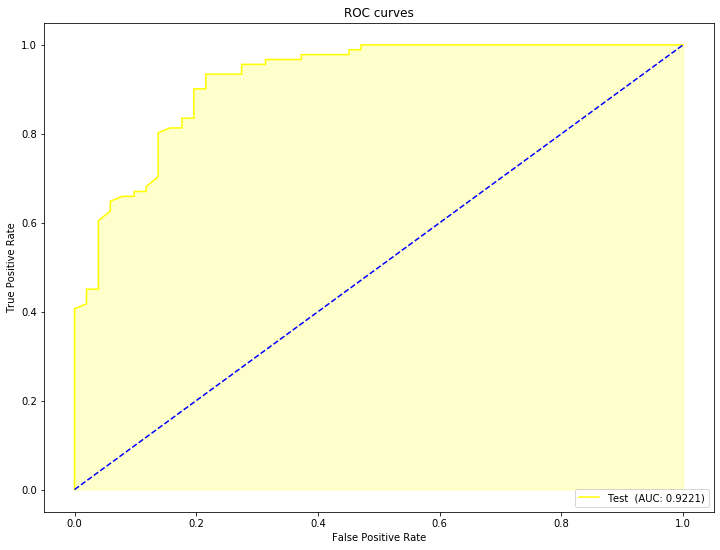

In [150]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict_proba(test[feature_columns])[:,1],
                        pos_label=1.0
                       )
df_roc_test = pd.DataFrame({"fpr":fpr, 
                            "tpr":tpr})

auc_test = roc_auc_score(test['status'], 
                         model.predict_proba(test[feature_columns])[:,1])

# ROC plotting
plt.figure(figsize=(12,9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"], "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0,1],[0,1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"], y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [151]:
auc_test

0.9221073044602457

In [152]:
auc_train = roc_auc_score(train3['status'], 
                         model.predict_proba(train3[feature_columns])[:,1])

In [153]:
auc_train

1.0

Sale similar al modelo sin validación cruzada repetida

**SIGUIENTES PASOS: VER NÚMERO DE VARIABLES RECOMENDADO SEGÚN NÚMERO OBSERVACIONES, PROBAR MODELO CON MENOS VARIABLES?? PROBAR ALGÚN OTRO ALGORITMO??**